In [1]:
import torch

import triton
import triton.language as tl
import matplotlib
import pandas as pd


In [2]:
@torch.jit.script
def naive_softmax(x):
    """Compute row-wise softmax of X using native pytorch

    We subtract the maximum element in order to avoid overflows. Softmax is invariant to
    this shift.
    """
    # read  MN elements ; write M  elements
    x_max = x.max(dim=1)[0]
    # read MN + M elements ; write MN elements
    z = x - x_max[:, None]
    # read  MN elements ; write MN elements
    numerator = torch.exp(z)
    # read  MN elements ; write M  elements
    denominator = numerator.sum(dim=1)
    # read MN + M elements ; write MN elements
    ret = numerator / denominator[:, None]
    # in total: read 5MN + 2M elements ; wrote 3MN + 2M elements
    return ret


In [3]:
@triton.jit
def softmax_kernel(
    output_ptr, input_ptr, input_row_stride, output_row_stride, n_cols,
    BLOCK_SIZE: tl.constexpr
):
    # The rows of the softmax are independent, so we parallelize across those
    row_idx = tl.program_id(0)
    # The stride represents how much we need to increase the pointer to advance 1 row
    row_start_ptr = input_ptr + row_idx * input_row_stride
    # The block size is the next power of two greater than n_cols, so we can fit each
    # row in a single block
    col_offsets = tl.arange(0, BLOCK_SIZE)
    input_ptrs = row_start_ptr + col_offsets
    # Load the row into SRAM, using a mask since BLOCK_SIZE may be > than n_cols
    row = tl.load(input_ptrs, mask=col_offsets < n_cols, other=-float('inf'))
    # Subtract maximum for numerical stability
    row_minus_max = row - tl.max(row, axis=0)
    # Note that exponentiation in Triton is fast but approximate (i.e., think __expf in CUDA)
    numerator = tl.exp(row_minus_max)
    denominator = tl.sum(numerator, axis=0)
    softmax_output = numerator / denominator
    # Write back output to DRAM
    output_row_start_ptr = output_ptr + row_idx * output_row_stride
    output_ptrs = output_row_start_ptr + col_offsets
    tl.store(output_ptrs, softmax_output, mask=col_offsets < n_cols)


In [4]:
def softmax(x):
    n_rows, n_cols = x.shape
    # The block size is the smallest power of two greater than the number of columns in `x`
    BLOCK_SIZE = triton.next_power_of_2(n_cols)
    # Another trick we can use is to ask the compiler to use more threads per row by
    # increasing the number of warps (`num_warps`) over which each row is distributed.
    # You will see in the next tutorial how to auto-tune this value in a more natural
    # way so you don't have to come up with manual heuristics yourself.
    num_warps = 4
    if BLOCK_SIZE >= 2048:
        num_warps = 8
    if BLOCK_SIZE >= 4096:
        num_warps = 16
    # Allocate output
    y = torch.empty_like(x)
    # Enqueue kernel. The 1D launch grid is simple: we have one kernel instance per row o
    # f the input matrix
    softmax_kernel[(n_rows,)](
        y,
        x,
        x.stride(0),
        y.stride(0),
        n_cols,
        num_warps=num_warps,
        BLOCK_SIZE=BLOCK_SIZE,
    )
    return y


In [6]:
def unit_test():
    torch.manual_seed(0)
    x = torch.randn(1823, 781, device='cuda')
    y_triton = softmax(x)
    y_torch = torch.softmax(x, axis=1)
    assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

unit_test()


In [7]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[
            128 * i for i in range(2, 100)
        ],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=[
            'triton',
            'torch-native',
            'torch-jit',
        ],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch (native)",
            "Torch (jit)",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('green', '--')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    )
)
def benchmark(M, N, provider):
    x = torch.randn(M, N, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch-native':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: softmax(x), quantiles=quantiles)
    if provider == 'torch-jit':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_softmax(x), quantiles=quantiles)
    gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


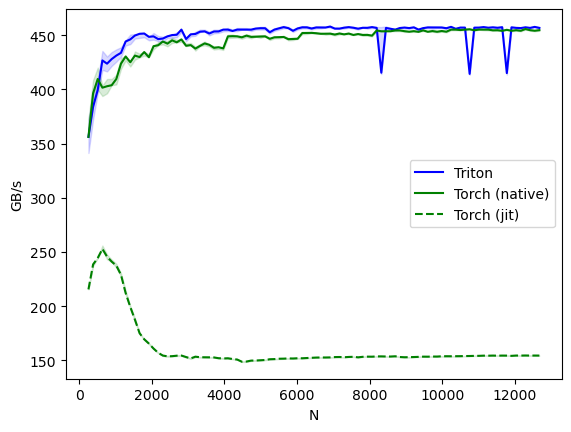

softmax-performance:
          N      Triton  Torch (native)  Torch (jit)
0     256.0  356.173905      356.173905   215.578957
1     384.0  384.000001      396.387102   238.601945
2     512.0  399.609763      409.600010   244.537310
3     640.0  426.666652      401.568635   252.839511
4     768.0  423.724127      402.885254   245.760006
..      ...         ...             ...          ...
93  12160.0  456.529426      454.049005   154.535341
94  12288.0  457.227922      455.638474   154.611613
95  12416.0  456.680466      454.590379   154.528462
96  12544.0  457.616133      454.081459   154.566039
97  12672.0  456.648644      454.600906   154.536588

[98 rows x 4 columns]


In [8]:
benchmark.run(show_plots=True, print_data=True)
